In [1]:
import os
from datetime import datetime
# Make logging folder named according to current time
start_time_str = datetime.today().strftime('%d_%m_%Y__%H_%M_%S')
log_dir = './logs/'f"log_{start_time_str}"
os.makedirs(log_dir)

# Initialize logger that adds to text file in current logging folder
from logging_utils import *

init_logger(save_dir=log_dir)
logger = get_logger()




In [2]:
import numpy as np
# A = np.matrix(
#     [[1, 1], 
#      [3, -4]]
# )

# A = np.matrix(
#     [[1, 1, 4], 
#      [3, -4, 0],
#      [0, 3 , 1]]
# )

A = np.matrix(
    [[-2, 1, 0, 0, 0], 
     [ 1,-2, 1, 0, 0],
     [ 0, 1,-2, 1,0],
     [ 0, 0, 1,-2, 1],
     [ 0, 0, 0, 1,-2]]
)

e = 0
nmax_iter = 10
retrain_freq=1
# x0 = np.array([0, 0])
# x0 = np.array([0,0,0])
x0 = np.array([0,0,0,0,0])

n_steps =1000
InputDim=5
HiddenDim=8
HiddenDim2=10
OutputDim=5

In [3]:
# Initial log message
logger.info(" Added  computation of cumulative moving average of 2-norm of residual for first GMRES iteration  to decotorator. Using this as the 'data addition critera' is excellent. Errors drop much faster without overfitting. Also, dimension of second hidden layer is now an input into decorator.")

2020-05-08 17:07:34 [INFO] <ipython-input-3-e2ba036a6d02> 2 -  Added  computation of cumulative moving average of 2-norm of residual for first GMRES iteration  to decotorator. Using this as the 'data addition critera' is excellent. Errors drop much faster without overfitting. Also, dimension of second hidden layer is now an input into decorator.


In [4]:
# Set up parameter class
class MyParamsClass():
    def __init__(self, A,nmax_iter,retrain_freq,e,x0,n_steps,InputDim,HiddenDim,HiddenDim2,OutputDim):
        self.A = A.tolist()
        self.nmax_iter = nmax_iter
        self.n_steps =n_steps
        self.retrain_freq=retrain_freq
        self.e=e
        self.x0=x0.tolist()
        self.InputDim=InputDim
        self.HiddenDim=HiddenDim
        self.HiddenDim2=HiddenDim2
        self.OutputDim=OutputDim

In [5]:
import os
import json

params = MyParamsClass(A,nmax_iter,retrain_freq,e,x0,n_steps,InputDim,HiddenDim,HiddenDim2,OutputDim)
sorted_params_dict = {k: params.__dict__[k] for k 
                      in sorted(params.__dict__.keys())}

params_filepath = log_dir+'/params.json'
json.dump(sorted_params_dict, open(params_filepath, 'w'), indent=4)

In [6]:
from src_dir import *

In [7]:
@nn_preconditioner(retrain_freq=retrain_freq, debug=True,InputDim=InputDim,HiddenDim=HiddenDim,HiddenDim2=HiddenDim2,OutputDim=OutputDim )
def MLGMRES(A, b, x0, e, nmax_iter,IterErr0_sum,ProbCount):
    return GMRES(A, b, x0, e, nmax_iter)
    

In [8]:
Training_Iterations=np.arange(0,n_steps)

Error0=np.zeros((1,n_steps))
Error1=np.zeros((1,n_steps))
Error2=np.zeros((1,n_steps))
Error3=np.zeros((1,n_steps))
Error4=np.zeros((1,n_steps))
Error5=np.zeros((1,n_steps))

Error0_ML=np.zeros((1,n_steps))
Error1_ML=np.zeros((1,n_steps))
Error2_ML=np.zeros((1,n_steps))
Error3_ML=np.zeros((1,n_steps))
Error4_ML=np.zeros((1,n_steps))

In [9]:
Window=50

In [10]:
IterErr0_sum=0.0

for ProbIdx in range(n_steps):
    b =12*np.squeeze(np.random.randn(1,5))  #random b
    b_norm=np.linalg.norm(b)
    Out,IterErr0_sum=MLGMRES(A, b/b_norm, x0, e, nmax_iter,IterErr0_sum,ProbIdx)  # normalize b for optimal NN performance
    Error0_ML[:,ProbIdx]=np.linalg.norm(np.dot(A,Out[0])-b/b_norm) # Error ML Iteration 1
    Error1_ML[:,ProbIdx]=np.linalg.norm(np.dot(A,Out[1])-b/b_norm) # Error ML Iteration 2
    Error2_ML[:,ProbIdx]=np.linalg.norm(np.dot(A,Out[2])-b/b_norm) # Error ML Iteration 3
    Error3_ML[:,ProbIdx]=np.linalg.norm(np.dot(A,Out[3])-b/b_norm) # Error ML Iteration 4
    Error4_ML[:,ProbIdx]=np.linalg.norm(np.dot(A,Out[4])-b/b_norm) # Error ML Iteration 5

    NonML_Out=GMRES(A, b/b_norm, x0, e, nmax_iter)
    Error0[:,ProbIdx]=np.linalg.norm(np.dot(A,NonML_Out[0])-b/b_norm) # Error GMRES Iteration 1
    Error1[:,ProbIdx]=np.linalg.norm(np.dot(A,NonML_Out[1])-b/b_norm) # Error GMRES Iteration 2
    Error2[:,ProbIdx]=np.linalg.norm(np.dot(A,NonML_Out[2])-b/b_norm) # Error GMRES Iteration 3
    Error3[:,ProbIdx]=np.linalg.norm(np.dot(A,NonML_Out[3])-b/b_norm) # Error GMRES Iteration 4
    Error4[:,ProbIdx]=np.linalg.norm(np.dot(A,NonML_Out[4])-b/b_norm) # Error GMRES Iteration 5
    Error5[:,ProbIdx]=np.linalg.norm(np.dot(A,NonML_Out[5])-b/b_norm) # Error GMRES Iteration 5
    print(ProbIdx)

0
1
2
3
4
5
retraining
1
6
7
retraining
2
8
retraining
3
9
10
retraining
4
11
12
13
14
15
16
retraining
5
17
18
19
retraining
6
20
21
22
retraining
7
23
24
retraining
8
25
retraining
9
26
retraining
10
27
28
retraining
11
29
30
31
32
33
34
35
36
retraining
12
37
retraining
13
38
retraining
14
39
retraining
15
40
41
retraining
16
42
retraining
17
43
retraining
18
44
45
46
47
48
49
retraining
19
50
51
52
53
54
55
56
retraining
20
57
retraining
21
58
59
60
61
62
retraining
22
63
64
65
retraining
23
66
67
68
69
70
71
72
73
74
retraining
24
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
retraining
25
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
retraining
26
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
retraining
27
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
1

In [11]:
print(np.mean(Error0_ML))
print(np.mean(Error1_ML))
print(np.mean(Error2_ML))
print(np.mean(Error3_ML))
print(np.mean(Error4_ML))

print('')

print(np.mean(Error0))
print(np.mean(Error1))
print(np.mean(Error2))
print(np.mean(Error3))
print(np.mean(Error4))
# print(np.mean(Error5))


1.2810954853954395
0.0623101706140098
0.0288278519983889
0.014172390494021912
0.007081931421234754

3.1727893862570817
0.47787568876122627
0.2896819030658452
0.16808969485885436
0.07635215328128338


In [12]:
import matplotlib.pyplot as pp

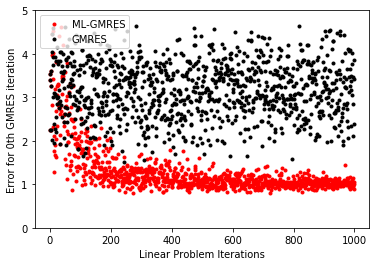

In [13]:
pp.plot(Training_Iterations,np.squeeze(Error0_ML),'.r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error0),'.k',label='GMRES')
pp.ylabel('Error for 0th GMRES iteration')
pp.xlabel('Linear Problem Iterations')
pp.legend(loc="upper left")
pp.savefig(log_dir+'/Iter0.png')
pp.ylim((0, 5)) 
pp.show()

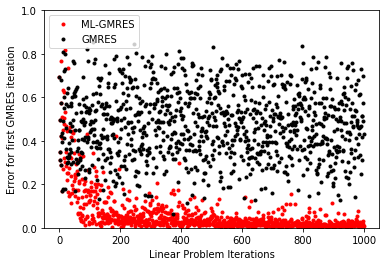

In [14]:
pp.plot(Training_Iterations,np.squeeze(Error1_ML),'.r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error1),'.k',label='GMRES')
pp.ylabel('Error for first GMRES iteration')
pp.legend(loc="upper left")
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter1.png')
pp.ylim((0, 1)) 
pp.show()

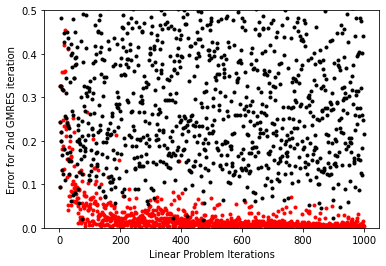

In [15]:
pp.plot(Training_Iterations,np.squeeze(Error2_ML),'.r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error2),'.k',label='GMRES')
pp.ylabel('Error for 2nd GMRES iteration')
pp.xlabel('Linear Problem Iterations')
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter2.png')
pp.ylim((0, .5)) 

pp.show()

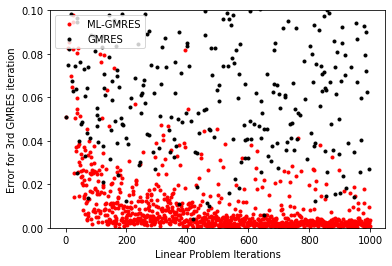

In [16]:
pp.plot(Training_Iterations,np.squeeze(Error3_ML),'.r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error3),'.k',label='GMRES')
pp.ylabel('Error for 3rd GMRES iteration')
pp.ylim((0, 0.1)) 
pp.legend(loc="upper left")
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter3_zoom.png')
pp.show()

In [17]:
# logger.info("Further checking overfitting situation. Results look good even with large problem iteration count. It seems best to train often initially to avoid overfitting, and then filter out potential data if current model prediction is within tolerance. It seems vital to avoid adding repetive data to training set. This initial frequent training to avoid overfitting due to repetitive data seems to be a feature of the fact the problem is extremely simple.")

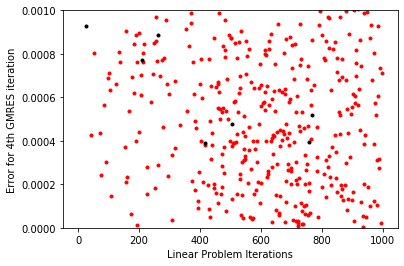

In [18]:
pp.plot(Training_Iterations,np.squeeze(Error4_ML),'.r',label='ML-GMRES')
pp.plot(Training_Iterations,np.squeeze(Error4),'.k',label='GMRES')
pp.ylabel('Error for 4th GMRES iteration')
pp.xlabel('Linear Problem Iterations')
pp.savefig(log_dir+'/Iter4.png')
pp.ylim((0, 0.001)) 

pp.show()